In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# setting seed for model reproducibility
seed_value = 42
import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)
import pandas as pd
from    missingno import matrix
import scipy.stats as stats
from pathlib import Path
import fnmatch
from collections import defaultdict

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from tensorflow import keras
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, GRU, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2
from keras import optimizers
from keras.optimizers import Adam
from time import time
from timeit import default_timer as timer

# For Genetic Algorithm
from random import shuffle, choice, sample, random, randint, uniform
from operator import attrgetter
from copy import deepcopy
from numpy import std

In [3]:
df = pd.read_csv('/content/gdrive/My Drive/Thesis/Final_Real.csv', index_col=0)

In [4]:
# Splitting the dataset
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=seed_value)

In [6]:
# Rescale the features

scaler = StandardScaler() 
train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),
                                     index=X_train.index,
                                     columns=X_train.columns)
# The Scaler is fit on the training set and then applied to the test set
test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                                    index=X_test.index,
                                    columns=X_test.columns)

train_scaled.shape, test_scaled.shape

((164563, 6), (70527, 6))

In [7]:
class GeneticAlgorithm:

    gene_bits = [8,6,5,7] 

    chromosome_length = sum(gene_bits)

    parameters = 4
    populations = 3
    generations = 3

    mu_p = 0.2

    def __init__(self):
        self.gene = [random.randint(0,1) for i in range(self.chromosome_length)]
        self.fitness = None
        self.phenoType = []
        self.convert_to_phenotype()

    def convert_to_phenotype(self):
        self.phenoType = []
        boundary = 0
        for each in self.gene_bits:
            self.phenoType.append(int(''.join(map(str,self.gene[boundary:boundary+each])),2))
            boundary += each

    def convert_to_genotype(self):
        gene = []
        for i, param in enumerate(self.phenoType):
            binary_ = '{0:0' + str(self.gene_bits[i]) + 'b}'
            gene.extend(list(binary_.format(param)))
        gene = [int(each) for each in gene]
        self.gene = gene

    def crossover(self, model_1,model_2,crossover_point):
        self.gene = model_1.gene[:crossover_point] + model_2.gene[crossover_point:]
        self.convert_to_phenotype()

    def mutate(self):
        boundary = 0
        change_points = []
        for each in self.gene_bits:
            change_points.append(random.randint(boundary,boundary+each-1))
            boundary += each
        for change_point in change_points:
            self.gene[change_point] = 1 - self.gene[change_point]
        self.convert_to_phenotype()

    def set_fitness(self, fitness_value):
        self.fitness = fitness_value

In [25]:
import random
phenotypes=[]
population = [GeneticAlgorithm() for i in range(GeneticAlgorithm.populations)]
for each in population:
  print(each.phenoType)
  phenotypes.append(each.phenoType)

[65, 18, 9, 105]
[157, 36, 15, 99]
[125, 61, 1, 37]


In [26]:
genotypes = []
for index,individual in enumerate(population):
  individual.phenoType = phenotypes[index]
  individual.convert_to_genotype()
  genotypes.append(each.gene)
print(genotypes)

[[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1], [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1], [0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1]]


In [27]:
def fitness_f1score(y_test_1, y_pred):
    fitness = round((f1_score(y_test_1, y_pred, average='weighted')), 4)
    return fitness

def get_fitness(self):

    X_train_1, y_train_1 = [], []
    
    for i in range(y_train.shape[0] - (each.phenoType[0]-1)):
        X_train_1.append(train_scaled.iloc[i:i+each.phenoType[0]].values)
        y_train_1.append(y_train.iloc[i + (each.phenoType[0]-1)])
    X_train_1, y_train_1 = np.array(X_train_1), np.array(y_train_1).reshape(-1,1)
    print(f'Train data dimensions: {X_train_1.shape}, {y_train_1.shape}')

    X_test_1, y_test_1 = [], []
    for i in range(y_test.shape[0] - (each.phenoType[0]-1)):
      X_test_1.append(test_scaled.iloc[i:i+each.phenoType[0]].values)
      y_test_1.append(y_test.iloc[i + (each.phenoType[0]-1)])
    X_test_1, y_test_1 = np.array(X_test_1), np.array(y_test_1).reshape(-1,1)  
    print(f'Test data dimensions: {X_test_1.shape}, {y_test_1.shape}')

    # GRU model with 2 stucked GRU layers with activation function relu

    model = Sequential()
    model.add(GRU(each.phenoType[1], kernel_initializer=keras.initializers.glorot_uniform(seed=seed_value), activation="relu", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
    model.add(GRU(each.phenoType[1], kernel_initializer=keras.initializers.glorot_uniform(seed=seed_value), activation='relu'))
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    print(model.summary())

    # Define a learning rate decay method:
    lr_decay = ReduceLROnPlateau(monitor='loss', 
                            patience=1, verbose=1, 
                            factor=0.5, min_lr=1e-8)
    # Define Early Stopping:
    early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                          patience=30, verbose=1, mode='auto',
                          baseline=0, restore_best_weights=True)

    History = model.fit(X_train_1, y_train_1,
                    epochs=each.phenoType[2],
                    batch_size=each.phenoType[3],
                    validation_data=(X_test_1, y_test_1),
                    shuffle=True,verbose=1,
                    callbacks=[lr_decay, early_stop])
    
    y_pred = np.argmax(model.predict(X_test_1), axis=-1)
        
    each.set_fitness(fitness_f1score(y_test_1, y_pred))
    print("F1 score is", each.fitness) 
    return each.fitness

In [28]:
def get_fittest():
    fitnesses = [each.fitness for each in population]
    total = sum(fitnesses)
    probability = [float(i/total) for i in fitnesses]
    return probability 

In [29]:
start = timer()

best_fitness_list = []

for generation_ in range(GeneticAlgorithm.generations): 
    print("\n\nGeneration "+str(generation_+1))
    fitness_list = []
    for each in population:
        print("Phenotype ",each.phenoType)
        fitness = get_fitness(each)
        fitness_list.append(fitness)
        print(fitness_list)
                
    probability = get_fittest()
    new_population = []

    # Retain best performing model to next generation
    best_model = probability.index(max(probability))
    print("Best model, generation {}, is {}".format(generation_+1,population[best_model].phenoType))

    print("Best model fitness, generation {}, is {}".format(generation_+1,population[best_model].fitness))
    best_fitness_list.append(population[best_model].fitness)
    new_population.append(population[best_model])

    
    for i in range(1,len(population)):
        point = random.random()
        accumulated_probability = probability[0]
        parent_1 = None
        parent_2 = None
        parent_1_index = None
        for j in range(len(population)):
            
            if point < accumulated_probability:
                parent_1 = population[j]
                parent_1_index = j
                break
            else:
                accumulated_probability += probability[j+1]

        second_parent_selected = False
        while not second_parent_selected:
            point = random.random()
            accumulated_probability = probability[0]
            for j in range(len(population)):
                if point < accumulated_probability and population[j].phenoType != population[parent_1_index].phenoType:
                    parent_2 = population[j]
                   
                    second_parent_selected = True
                    break
                else:
                    accumulated_probability += probability[j]
        
        new_individual = GeneticAlgorithm()
        crossover_point = sum(GeneticAlgorithm.gene_bits[:len(GeneticAlgorithm.gene_bits)//random.randint(2,len(GeneticAlgorithm.gene_bits)-1)])
        new_individual.crossover(parent_1, parent_2, crossover_point=crossover_point)

        if random.random() < GeneticAlgorithm.mu_p:
            new_individual.mutate()

        new_population.append(new_individual)
    population = new_population
end = timer()
print("time taken = ",end-start)
print(population)





Generation 1
Phenotype  [65, 18, 9, 105]
Train data dimensions: (164499, 65, 6), (164499, 1)
Test data dimensions: (70463, 65, 6), (70463, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 65, 18)            1404      
                                                                 
 gru_5 (GRU)                 (None, 18)                2052      
                                                                 
 dense_2 (Dense)             (None, 9)                 171       
                                                                 
Total params: 3,627
Trainable params: 3,627
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/9
1567/1567 [==============================] - 144s 90ms/step - loss: 0.4359 - accuracy: 0.8777 - val_loss: 0.2462 - val_accuracy: 0.9310 - lr: 0.0010
Epoch 2/

In [30]:
best_fitness_list

[0.9714, 0.976, 0.9792]

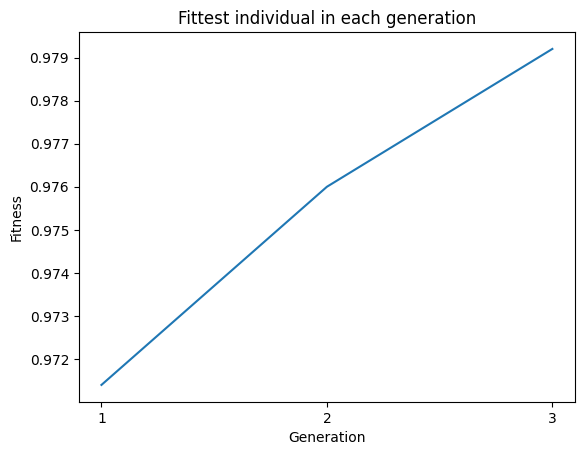

In [46]:
generations = range(1, len(best_fitness_list) + 1)

plt.plot(generations, best_fitness_list)
plt.title('Fittest individual in each generation')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.xticks(np.arange(1, 4, step=1))
plt.show()

In [39]:
print("Best model is {}".format(population[best_model].phenoType))

Best model is [125, 61, 15, 99]


In [34]:
best = population[best_model].phenoType

In [35]:
# Train the model using best configuration on complete training set 
#and make predictions on the test set

T = best[0]
X_train_1, y_train_1 = [], []
for i in range(y_train.shape[0] - (T-1)):
  X_train_1.append(train_scaled.iloc[i:i+T].values)
  y_train_1.append(y_train.iloc[i + (T-1)])
X_train_1, y_train_1 = np.array(X_train_1), np.array(y_train_1).reshape(-1,1)
print(f'Train data dimensions: {X_train_1.shape}, {y_train_1.shape}')

X_test_1, y_test_1 = [], []
for i in range(y_test.shape[0] - (T-1)):
  X_test_1.append(test_scaled.iloc[i:i+T].values)
  y_test_1.append(y_test.iloc[i + (T-1)])
X_test_1, y_test_1 = np.array(X_test_1), np.array(y_test_1).reshape(-1,1)  
print(f'Test data dimensions: {X_test_1.shape}, {y_test_1.shape}')

# GRU model with 2 stucked GRU layers with activation function relu

model = Sequential()
model.add(GRU(best[1], activation="relu", return_sequences=True, input_shape=(X_train_1.shape[1],  X_train_1.shape[2])))
model.add(GRU(best[1], activation='relu'))
model.add(Dense(9, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
print(model.summary())


# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                                patience=1, verbose=1, 
                                factor=0.5, min_lr=1e-8)
# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                              patience=30, verbose=1, mode='auto',
                              baseline=0, restore_best_weights=True)

# Train the model. 
start = time()
History = model.fit(X_train_1, y_train_1,
                        epochs=best[2],
                        batch_size=best[3],
                        validation_data=(X_test_1, y_test_1),
                        shuffle=True,verbose=1,
                        callbacks=[lr_decay, early_stop])
print('-'*65)
print(f'Training was completed in {time() - start:.2f} secs')
print('-'*65)

y_pred = np.argmax(model.predict(X_test_1), axis=-1)


Train data dimensions: (164439, 125, 6), (164439, 1)
Test data dimensions: (70403, 125, 6), (70403, 1)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_22 (GRU)                (None, 125, 61)           12627     
                                                                 
 gru_23 (GRU)                (None, 61)                22692     
                                                                 
 dense_11 (Dense)            (None, 9)                 558       
                                                                 
Total params: 35,877
Trainable params: 35,877
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/15
1661/1661 [==============================] - 444s 264ms/step - loss: 0.2711 - accuracy: 0.9200 - val_loss: 0.1541 - val_accuracy: 0.9454 - lr: 0.0010
Epoch 2/15
1661/1661 [======================

<Axes: >

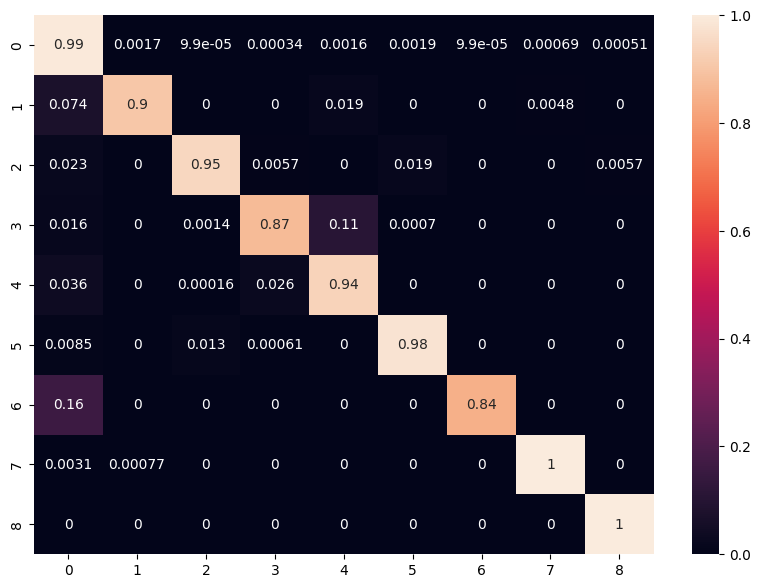

In [36]:
cm = confusion_matrix(y_test_1, y_pred)
cm = pd.DataFrame(data=cm, columns = np.unique(y_test_1), index = np.unique(y_test_1))
cm = (cm / cm.sum(axis = 1).values.reshape(-1,1))  # to fractions of 1
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True)

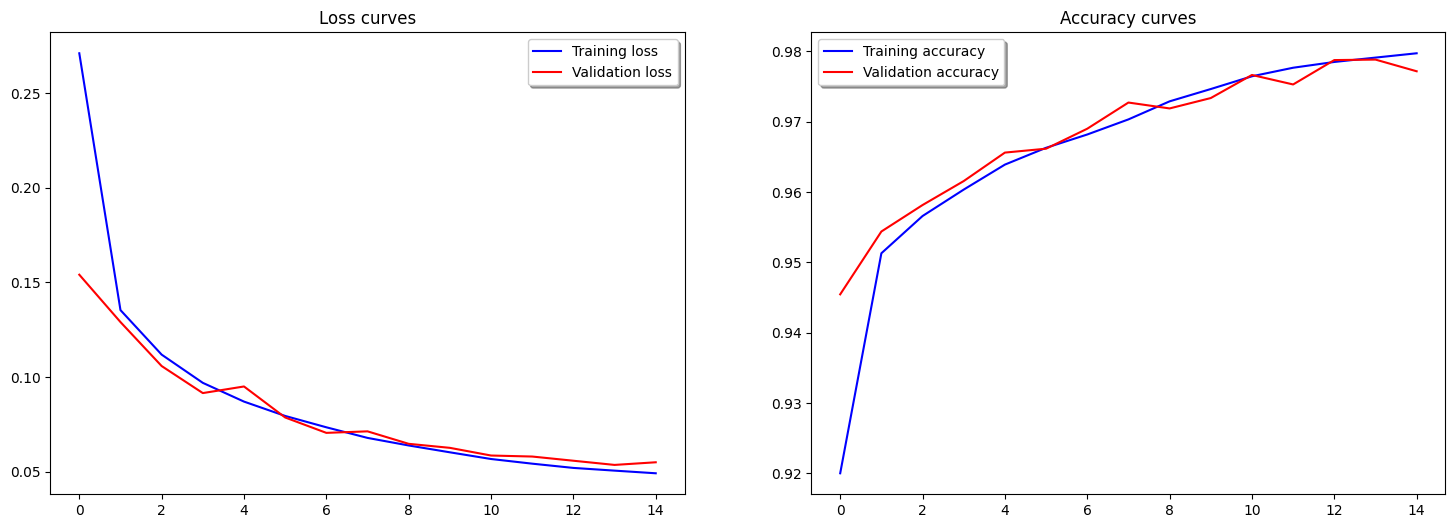

In [37]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)
plt.show()

In [38]:
# defining function for classification metrics
def clf_metrics(test, pred):
    '''Function returns basic metrics for classification models'''
    print('Classification Accuracy Score:', accuracy_score(test, pred))
    print('Confusion Matrix: \n', confusion_matrix(test, pred))
    print('Classification Report: \n', classification_report(test, pred, zero_division=0))
clf_metrics(y_test_1, y_pred)

Classification Accuracy Score: 0.9771600642018096
Confusion Matrix: 
 [[50386    85     5    17    79    96     5    35    26]
 [   31   379     0     0     8     0     0     2     0]
 [   12     0   502     3     0    10     0     0     3]
 [   46     0     4  2495   305     2     0     0     0]
 [  452     0     2   324 11650     0     0     0     0]
 [   14     0    21     1     0  1604     0     0     0]
 [   15     0     0     0     0     0    81     0     0]
 [    4     1     0     0     0     0     0  1288     0]
 [    0     0     0     0     0     0     0     0   410]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     50734
           1       0.82      0.90      0.86       420
           2       0.94      0.95      0.94       530
           3       0.88      0.87      0.88      2852
           4       0.97      0.94      0.95     12428
           5       0.94      0.98      0.96      1640
           6